# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

PROBLEM: 

Determining the right salary for current and prospective employees is always a bit tricky. Offering too low can turn away prospective and current talent; offering too much can make the business less competitive with not enough incentive for employees to work hard for better rewards. Most people look up average or median salaries for any job title and use that as an anchor. However, accounting for multiple other factors and the nature of their interactions can help us become much more objective, precise, and equitable for all parties.
This data contains features such as job title, education, industry, experience, and distance from metropolis to predict any given candidate's salary.

In [1]:
# impor all libraries
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import timeit
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings("ignore")

__author__ = "Tehseen Niaz"
__email__ = "tehseenniaz@gmail.com"

os.listdir()

['.ipynb_checkpoints',
 'catboost_info',
 'Salary Prediction Notebook.ipynb',
 'test_features.csv',
 'train_features.csv',
 'train_salaries.csv']

## Part 2 - DISCOVER

### 2.0 Load the data

In [2]:
# Load the data into a pandas dataframe
full_features_data = pd.read_csv("train_features.csv")
full_salary_data = pd.read_csv('train_salaries.csv')
prediction_data = pd.read_csv('test_features.csv') # this what we are predicting - it does not have true salary values

### 2.1 Define functions

In [4]:
def data_info(data):
    print('It has {0} rows and {1} columns\n'.format(*data.shape))
    print(data.head(5))

In [6]:
# plot distributions of numeric and categorical data
def data_viz(data, feature):
    if feature == 'salary':
        plt.figure (figsize = (30,7))
        sns.distplot(data[feature], bins=100)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.ylabel('Proportion', fontsize=12)
        plt.xlabel(feature, fontsize=12)
    else:
        plt.figure (figsize = (20,7))
        sns.countplot(data[str(feature)])
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.ylabel('Proportion', fontsize=12)
        plt.xlabel(str(feature), fontsize=12)

In [35]:
# function for visualizing categorical features against Salary
def salary_by_feature(feature):
    viz_df = train_features.copy()
    viz_df['Salary'] = train_salaries['salary'] # Appending salaries to df for easier EDA
    sns.set(style="ticks")
    g = sns.catplot(x=feature, y='Salary', data=viz_df, kind='box')
    g.fig.set_figwidth(15)
    g.fig.set_figheight(7)

In [8]:
# drop rows where salary = 0
def drop_zeros(df):
    df = df[full_salary_data.salary > 0]
    return df

In [9]:
# JobIDs uniquely ID each row
def drop_jobId(dataframes):
    for df in dataframes:
        df.drop('jobId', axis=1, inplace=True)

In [10]:
# To make the models more generalizable beyond a set of companies
def drop_companyId(dataframes):
    for df in dataframes:
        df.drop('companyId', axis=1, inplace=True)

In [11]:
# drop excluded groups to form a basis of comparison in regressions
def drop_base_groups(df):
    df.drop(['jobType_JANITOR', 'degree_NONE', 'major_NONE', 'industry_SERVICE'], axis=1, inplace = True)

In [12]:
def make_dummies(df):
    dummy_df = pd.get_dummies(df.copy())
    return dummy_df

In [13]:
def create_interactions(data):
    interactions = PolynomialFeatures(interaction_only=True, include_bias=False)
    df_interactions = interactions.fit_transform(data)
    return df_interactions

### ---- 3 Clean the data ----

#### 3.1 Check data for null values and dtypes 

In [16]:
full_features_data.info() # no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [17]:
full_salary_data.info() # no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   jobId   1000000 non-null  object
 1   salary  1000000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [18]:
prediction_data.info() # no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


##### There are no null values in any dataset, so we are good so far

#### 3.2 Check for duplication

In [19]:
full_features_data.duplicated().sum() # no duplicated rows

0

In [20]:
full_salary_data.duplicated().sum() # no duplicated rows

0

In [21]:
prediction_data.duplicated().sum() # no duplicated rows

0

#### 3.3 Check for invalid data (e.g. salaries <=0) or corrupt data and remove it

In [22]:
full_features_data.describe(include='all')

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000.000000,1000000.000000
unique,1000000,63,8,5,9,7,NaN,NaN
top,JOB1362685016189,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB,NaN,NaN
freq,1,16193,125886,236976,532355,143206,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,11.992386,49.529260
std,NaN,NaN,NaN,NaN,NaN,NaN,7.212391,28.877733
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,25.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,50.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,75.000000


We will further evaluate all these features in EDA but for now there aren't any reasons for concern.
The counts are equal; unique values and summary stats believable.

In [23]:
full_salary_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
salary,1000000.0,116.061818,38.717936,0.0,88.0,114.0,141.0,301.0


The min value shows 0 salary, which is a bit concerning since there's no "internship" or "pro bono" job type mentioned. Needs further examination.

In [24]:
full_features_data.loc[full_salary_data.salary==0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29


Makes no sense that these folks with all the skills and experience were working for free, so this is likely to be an error. We will drop them.

In [25]:
# dropping zero salary data from both datasets
full_features_data = drop_zeros(full_features_data)
full_salary_data = drop_zeros(full_salary_data)
# drop jobID as it uniquely identifies each row and companyId to make predictions generalizable
drop_jobId([full_features_data, full_salary_data, prediction_data])
drop_companyId([full_features_data, prediction_data])
print(full_features_data.shape)
print(full_salary_data.shape)
print(prediction_data.shape)

(999995, 6)
(999995, 1)
(1000000, 6)


#### Create training and testing sets for further analysis and model building

In [26]:
# Split
train_features, test_features, train_salaries, test_salaries = train_test_split(full_features_data, full_salary_data, test_size=0.25, random_state=4)
print(train_features.shape)
print(test_features.shape)
print(train_salaries.shape)
print(test_salaries.shape)

(749996, 6)
(249999, 6)
(749996, 1)
(249999, 1)


Now we are ready for exploratory data analysis

### ---- 4 Explore the data (EDA) ----

##### The plan is to:
1. Evaluate the distribution of each variable to be aware of any skews
2. Compare all numerical features with each other to see how much they correlate
3. Compare all categorical features with each other with crosstabs
4. Compare all numerical and categorical variables against salary

### 4.1 Explore salary and each categorical feature

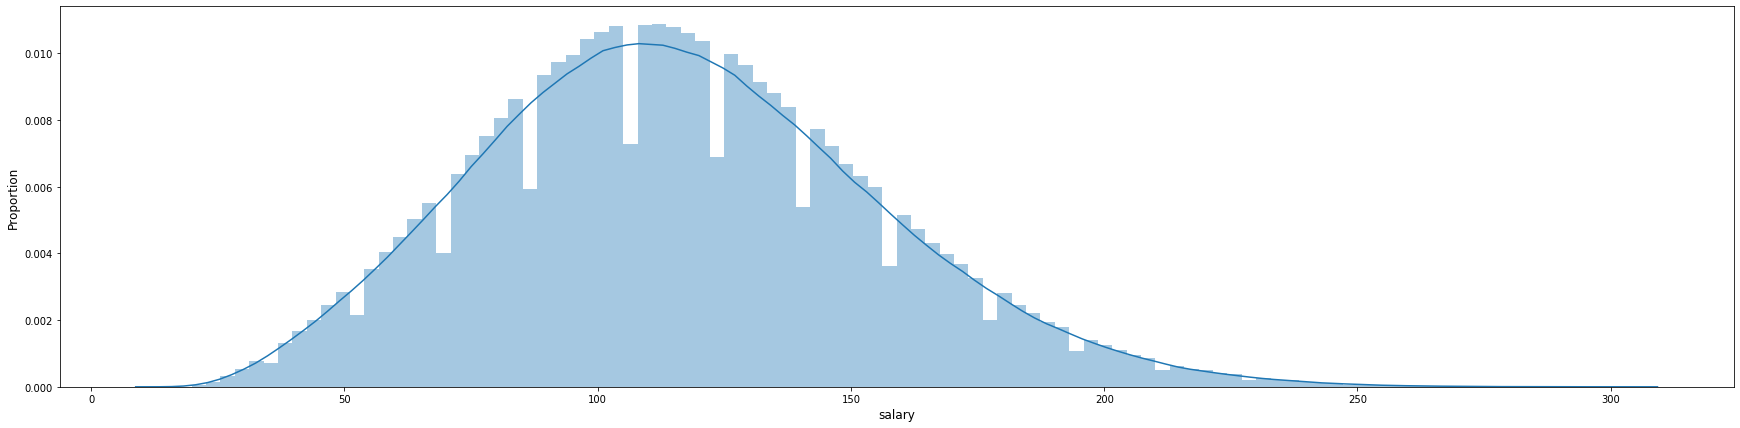

In [27]:
data_viz(train_salaries, 'salary')

Typical salary distribution with right-skew representing very high earners. I would log-transform but will not for two reasons:
1. The distribution is generally symmetric so it's not a big risk.
2. Saying our model is generally off by X thousand dollars is far easier to interpret for stakeholders than saying it is off by X log dollars.

##### Check JobType

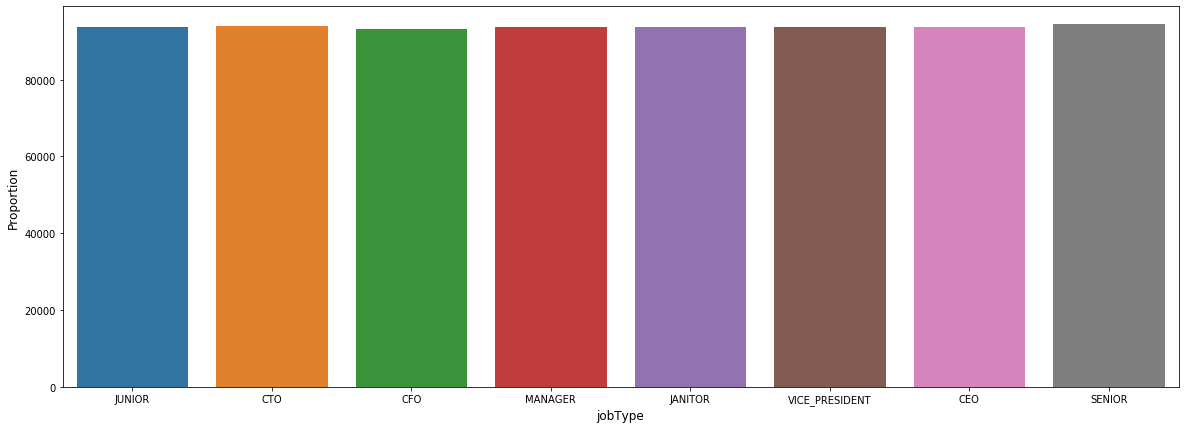

In [28]:
data_viz(train_features,'jobType')

Job type seems evenly distributed and alright

##### Check Degree

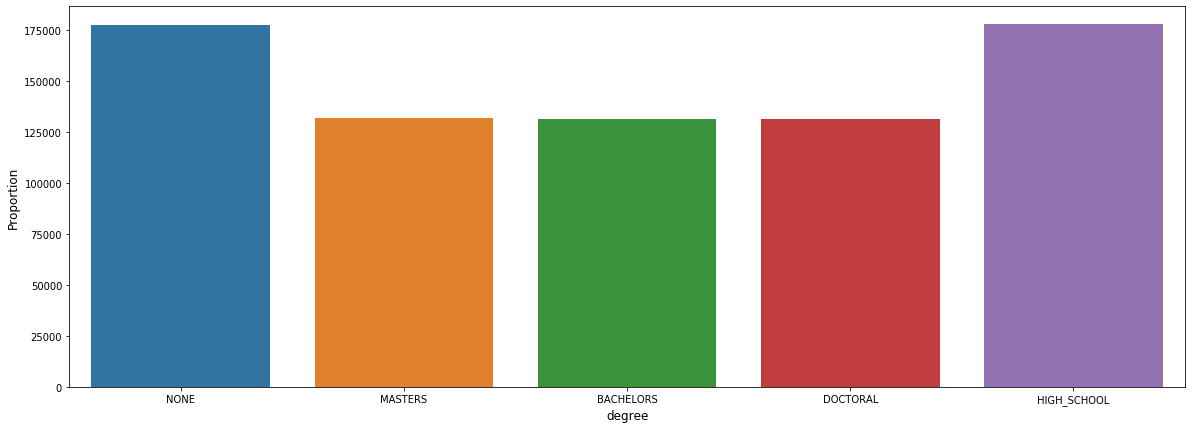

In [29]:
data_viz(train_features, 'degree')

Most have no or only high school education

##### Check Major

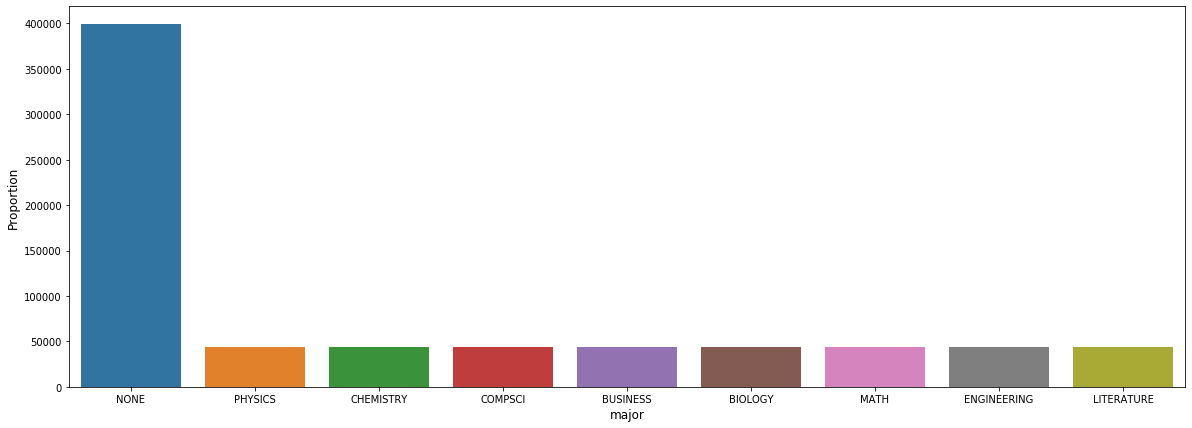

In [30]:
data_viz(train_features, 'major')

Looks consistent because most people had either only high school education or none at all so "None" major being the mode makes sense

##### Check Industry

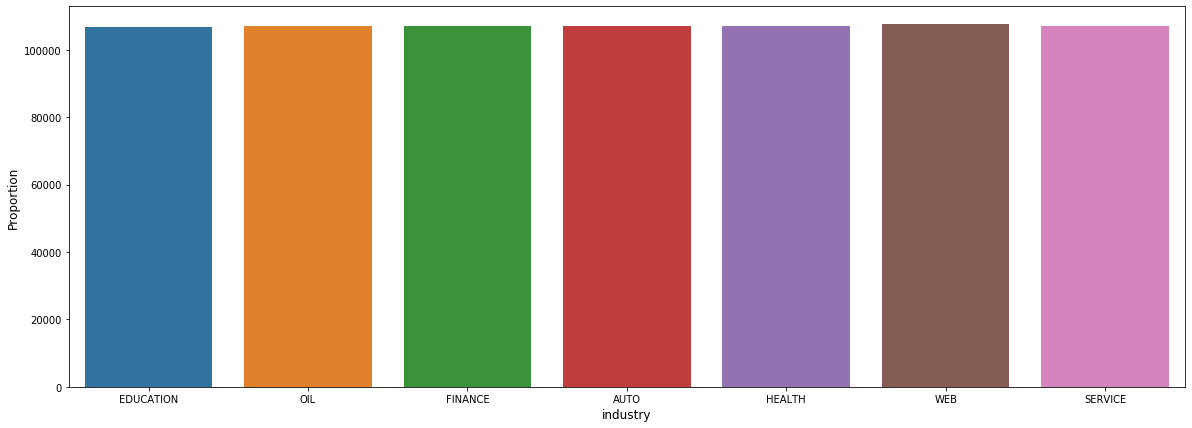

In [31]:
data_viz(train_features, 'industry')

Very evenly distributed - looks fine

##### Check yearsExperience

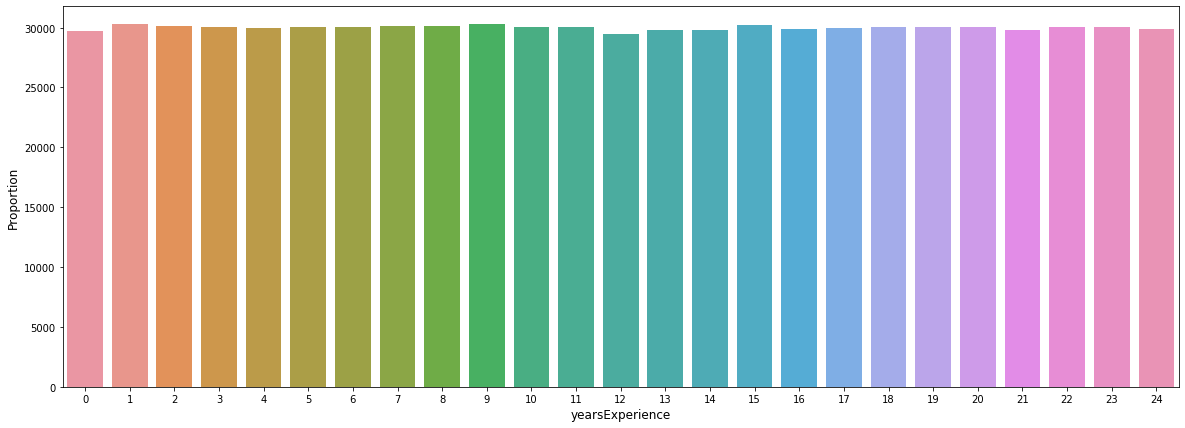

In [32]:
data_viz(train_features, 'yearsExperience')

Uniformly distributed with no apparent concerns

##### Check Distance

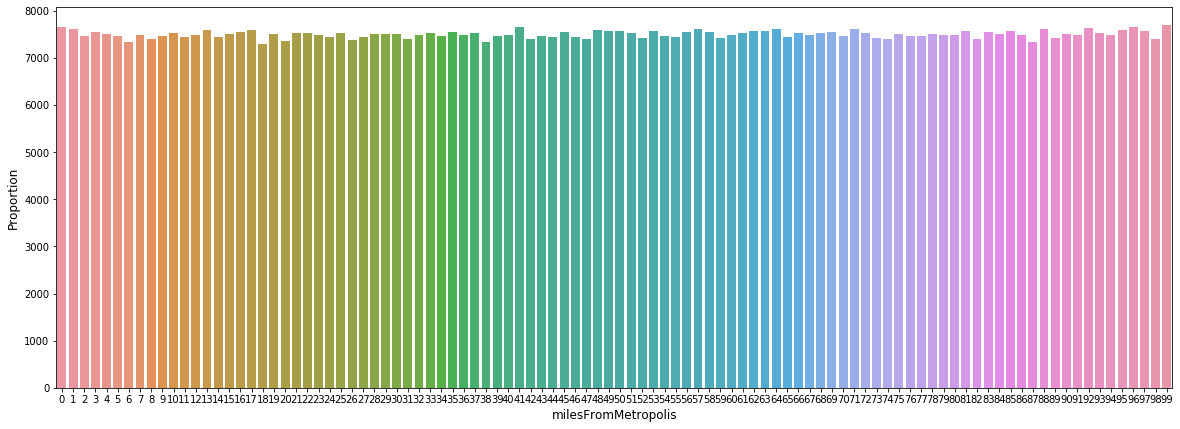

In [33]:
data_viz(train_features, 'milesFromMetropolis')

A bit strange that many people are living more than 50 miles from downtown. But city limits can be 10-50 miles from the metropolis and suburbs can extend to another 50 miles.

### 4.2 Evaluate each categorical feature against Salary

We could do ANOVA to check if there's a statistically significant difference across subcategories for each variable, but we're going to use all variables anyway due to strong theoretical impetus, so just visual confirmation that salary even somewhat varies across subcategories is enough.

#### JobType vs Salary

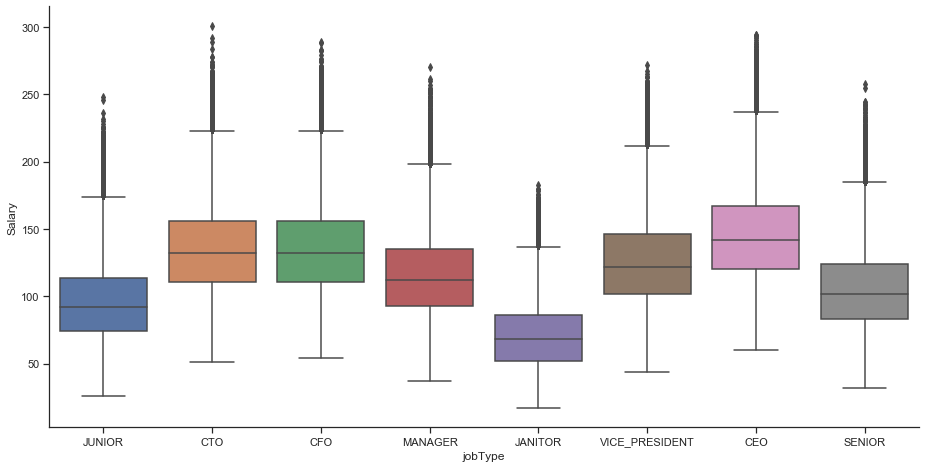

In [36]:
salary_by_feature('jobType')

Salary median varies by jobType, so it is potentially a good predictor.
Many janitors earn over 100k, so it should be checked for data accuracy.

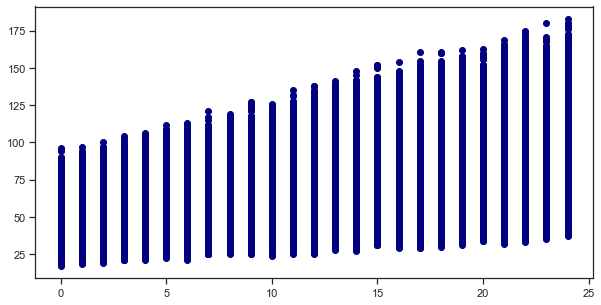

In [37]:
# Checking Janitor data because many janitors are earning well over 100k
janitor_experience = train_features['yearsExperience'].loc[train_features['jobType']=='JANITOR']
janitor_salary = train_salaries.loc[train_features['jobType']=='JANITOR']
plt.figure(figsize = (10,5))
plt.scatter(x=janitor_experience, y=janitor_salary, color='navy')

More experienced janitors earn more so data seems alright

#### Degree vs Salary

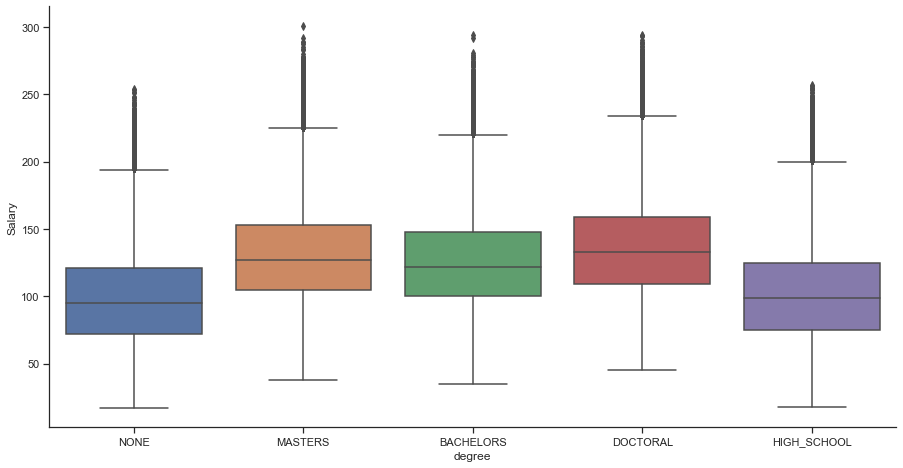

In [38]:
salary_by_feature('degree')

Higher education yields higher pay which makes sense

#### Major vs Salary

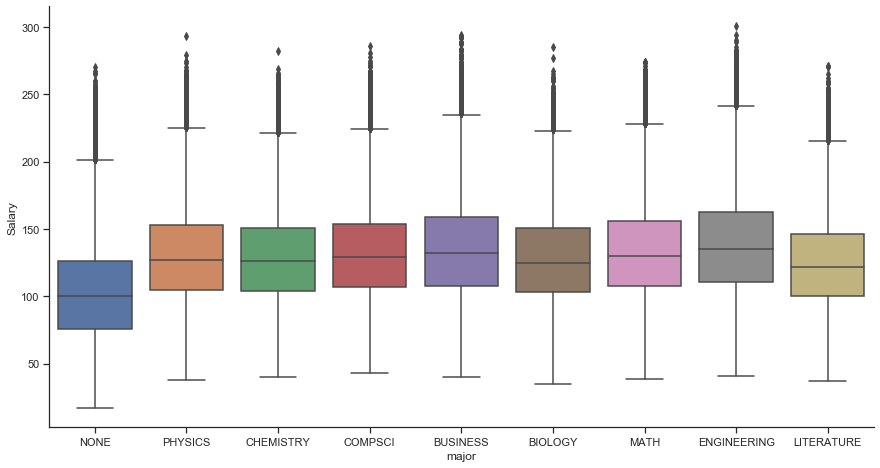

In [39]:
salary_by_feature('major')

Not a whole lot of variation in salary across majors given most are STEM. There could be significant difference in salaries by major itself after accounting for other variables which might be masking the true effect. We know that some majors typically earn more than others, everything else held constant.

#### Industry vs Salary

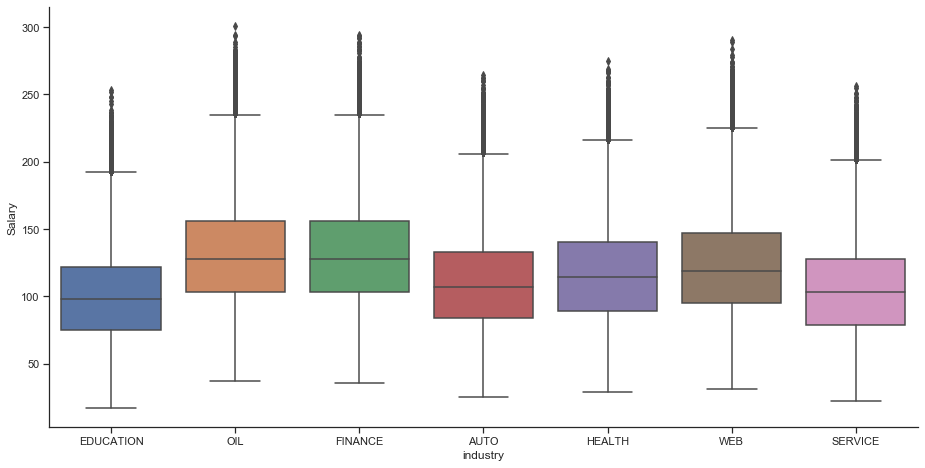

In [40]:
salary_by_feature('industry')

Palpable variation across industry as well where oil and finance stand out at top (surprising?)

### 4.3 -- Evaluate numeric features against Salary

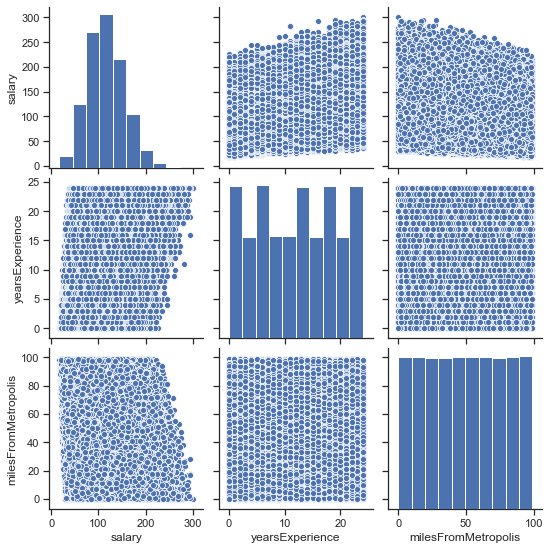

In [41]:
numeric_vars_df = train_features[['milesFromMetropolis', 'yearsExperience']]
numeric_vars_df['salary'] = train_salaries['salary']
sns.pairplot(numeric_vars_df, vars=['salary', 'yearsExperience', 'milesFromMetropolis'])

Since there's no curvature in the plots, measuring linear association with correlation is appropriate

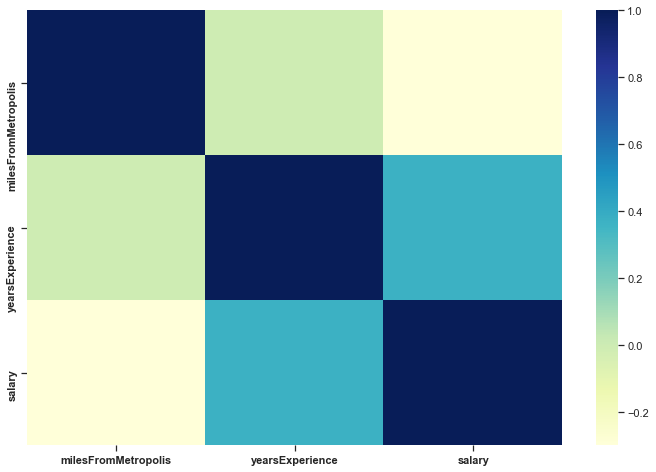

In [50]:
corr = numeric_vars_df.corr() # heat map
plt.figure(figsize = (12,8))
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
sns.heatmap(corr, cmap="YlGnBu")

Salary is higher with more experience.

Salary is lower as distance from metropolis increases.

Experience and distance have almost no correlation.

### ---- 5 Establish a baseline ----

We will predict salary using industry median to establish a baseline prediction method for comparison

In [51]:
train_df = train_features.copy()
train_df['salary'] = train_salaries['salary']
baseline_df = train_df.groupby('industry', as_index=False).median()
baseline_df = baseline_df[['industry', 'salary']]

In [52]:
merged = baseline_df.merge(train_features, on='industry')
merged.head(5)

,industry,salary,jobType,degree,major,yearsExperience,milesFromMetropolis
0,AUTO,107,MANAGER,NONE,NONE,20,88
1,AUTO,107,JANITOR,NONE,NONE,6,3
2,AUTO,107,CTO,BACHELORS,PHYSICS,10,54
3,AUTO,107,CTO,DOCTORAL,COMPSCI,20,84
4,AUTO,107,MANAGER,BACHELORS,COMPSCI,5,48


In [54]:
mean_squared_error(merged['salary'], train_df['salary'])

1624.2382039370877

We need to do better than MSE of 1624, which is like making an error of about 40k USD on average per prediction.

### ---- 6 Hypothesize solution ----

Brainstorm models

Capture linear associations between variables and target:
- Linear Regression
- Linear Regression with interactions

Capture non-linear relations in the feature space:
- Random Forest - regression trees with bagging and sampled features
- Light GBM - leaf-wise splitter that is a lot faster than most other boosting methods with comparable or better performance

Combination
- Stacking

## Part 3 - DEVELOP

#### Metric will be MSE and assigned goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [55]:
# make dummy variables
dummy_train = make_dummies(train_features)
dummy_train.shape

(749996, 31)

In [56]:
# transform testing data
dummy_test = make_dummies(test_features)
dummy_test.shape

(249999, 31)

In [57]:
# Drop the excluded group in each category to form a basis of comparison in regressions
drop_base_groups(dummy_train)
print(dummy_train.shape)

drop_base_groups(dummy_test)
print(dummy_test.shape)

(749996, 27)
(249999, 27)


In [58]:
train_features.columns

Index(['jobType', 'degree', 'major', 'industry', 'yearsExperience',
       'milesFromMetropolis'],
      dtype='object')

---------------------------------------------------------------------------------------------------
### Interactions justifications:

- JobType * Industry

CFO in finance industry should earn more than a CFO in education, which means that the effect of job type on salary depends on industry, so they interact.

- JobType * Degree --- | --- JobType * Major

A CTO with literature major ought to earn differently from a CTO with computer science major.

- JobType * yearsExperience

25 years of experience as a janitor ought to be different from same experience as a senior, so salary changes due to experience differs by job type.
- yearsExperience * Degree --- | --- yearsExperience * Major

Experience is also substituted for level and relevance of education, so effect of experience on salary also depends on education.

- yearsExperience * Industry

Experience in one industry might be differently rewarded from another.

- Industry * Degree --- | --- Industry * Major

Differnet industries ought to reward different education levels and majors differently.

- Degree * Major

Finance Master's ought to earn more than just Finance Bachelor's.

- milesFromMetropolis * JobType

A senior manager in multinational's downtown office ought to earn differently from a senior manager living and working near the suburbs in a medium enterprise.

- milesFromMetropolis * Degree -- | -- milesFromMetropolis * Major

Those who can afford living in the metropolis might have better resources to pursue higher education and STEM subjects that pay more.

- milesFromMetropolis * Industry

Finance employees who live in suburbs might be more likely to choose an industry closer to home (say, schools and colleges) rather than working in the financial district downtown.

- milesFromMetropolis * Experience

Each additional year of experience might be differently rewarded by firms that can afford to have premises in downtown versus ones farther away from it.

#### We have JobType, yearsExperience, milesFromMetropolis, industry, degree, and major all interacting with each other

----------------------------------------------------------------------------------------------------

In [59]:
# Creating interaction variables
df_interactions = create_interactions(dummy_train)
df_interactions

array([[18., 71.,  0., ...,  0.,  0.,  0.],
       [ 0., 94.,  0., ...,  0.,  0.,  0.],
       [ 9., 24.,  0., ...,  0.,  0.,  0.],
       ...,
       [12., 59.,  0., ...,  0.,  0.,  0.],
       [23., 61.,  0., ...,  0.,  0.,  0.],
       [ 2., 26.,  0., ...,  0.,  0.,  0.]])

##### These are many variables, but given that the data is quite balanced across all subcategories, we will have roughly 2000 data points for each variable

### ---- 8 Create and evaluate models ----

In [60]:
# Take an estimator and output cross-validated MSE scores
def estimator_cv(estimator, cv, data, target):
    scores = cross_val_score(estimator, X=data, y=target, cv=cv, scoring='neg_mean_squared_error')
    scores = abs(scores) # MSE scoring is negative in cross_val_score
    avg_scores = np.mean(scores)
    std = np.std(scores)
    print("avg_score:", avg_scores,'\n', "std.dev:", std)

#### Model 1: Linear Regression 

In [61]:
OLS_mse = estimator_cv(LinearRegression(), cv=5, data=dummy_train, target=train_salaries)
OLS_mse

avg_score: 384.7288188645689 
 std.dev: 1.0638518603884346


#### Model 2: Linear Regression with interactions

In [62]:
MSE_interaction = estimator_cv(LinearRegression(), cv=5, data=df_interactions, target=train_salaries)
MSE_interaction

avg_score: 354.17053154036404 
 std.dev: 0.7667555980900301


#### Models 3, 4, and 5: [ Random Forest,  LightGBM,  Gradient Boosting ]
We will do randomized grid search to get quasi-optimal hyperparameters on the dummy_train data set. 

Since this is computationally very intensive, we used Google Colaboratory's fastest processors, Tensor Processing Units (TPUs), to get the tuned hyperparameters for evaluating performance on the testing set. 

This way we will run multiple instances of multiple models in Google Colab, but only a single instance of optimized models here.

In [63]:
# Parameter space
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 6)]
learning_rate = [0.01, 0.05, 0.1]
subsample = np.linspace(start = 0.1, stop = 1.0, num = 5)
max_depth = [int(x) for x in np.linspace(start = 1, stop = 35, num = 10)]
max_features = ['auto', 'sqrt']
num_leaves = [int(x) for x in np.linspace(start = 20, stop = 150, num = 10)]
colsample_bytree = np.linspace(start = 0.1, stop = 1.0, num = 5)

# Create the random grids
random_grid_rfr = {'n_estimators': n_estimators,
                  'max_features': max_features}

random_grid_lgbm = {'max_depth': max_depth, 'num_leaves':num_leaves}


random_grid_gbr = {'n_estimators': n_estimators,
                   'learning_rate': learning_rate,
                   'subsample': subsample, # stochastic gradient boosting
                   'max_depth': max_depth,
                   'max_features': max_features}

# initialize models
lgbm = LGBMRegressor()
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()

rfr_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid_rfr, n_iter=10, cv=3, 
                                return_train_score=True, random_state=42, scoring='neg_mean_squared_error')
lgbm_random = RandomizedSearchCV(estimator=lgbm, param_distributions=random_grid_lgbm, n_iter=20, cv=3, 
                                return_train_score=True, random_state=42, scoring='neg_mean_squared_error')
gbr_random = RandomizedSearchCV(estimator=gbr, param_distributions=random_grid_gbr, n_iter=10, cv=3, 
                                return_train_score=True, random_state=42, scoring='neg_mean_squared_error')

In [64]:
# evaluating multiple models with different combinations of hyperparameters
model_names = ['lgbm', 'rfr', 'gbr']

def multi_models_evaluation(models, data):
    counter = 0 # counter for model names
    for model in models:
        start = timeit.default_timer()
        model.fit(data, train_salaries)
            
        # log the results for printing
        results = model.cv_results_
        cv_scores = np.round(abs(results['mean_test_score']), 2)
        mean = np.round(np.mean(cv_scores), 2)
        std = np.round(np.std(cv_scores))
        best_score = abs(np.round(model.best_score_, 2))
            
        # printing
        print('model: ', model_names[counter]) 
        counter += 1
        print("\naverage score: ", mean, "\nstandard deviation: ", std)
        print("score with best parameters: ", best_score)
        print("best parameters: ", model.best_params_)
        stop = timeit.default_timer()
        execution_time = stop - start
        print("\nExecuted in "+str(round(execution_time/60, 2))+ " minutes\n") # It returns time in minutes

models = [lgbm_random, rfr_random, gbr_random]
#multi_models_evaluation(models, dummy_train)

#### Output of multi_models_evaluation from Google Colab:

model:  lgbm
- score with best parameters:  357.68
- average score:  400.76 
- standard deviation:  112.0
- best parameters:  {'num_leaves': 63, 'max_depth': 12}
- Executed in 7.24 minutes

model:  rfr
- score with best parameters:  444.17
- average score:  447.19 
- std dev:  2.0
- best parameters:  {'n_estimators': 150, 'max_features': 'sqrt'}
- Executed in 100.55 minutes

model:  gbr
- score with best parameters:  397.17
- average score:  540.69 
- standard deviation:  148.0
- best parameters:  {'subsample': 0.1, 'n_estimators': 130, 'max_features': 'auto', 'max_depth': 16, 'learning_rate': 0.05}
- Executed in 101.29 minutes

#### Models with 'best' hyperparameters as optimized above

In [65]:
best_lr = LinearRegression() # doesn't have any hyperparameters
lm_interactions = LinearRegression()
best_lgbm = LGBMRegressor(num_leaves=63, max_depth=12)
best_rfr = RandomForestRegressor(n_estimators=150, max_features='sqrt')
best_gbr = GradientBoostingRegressor(subsample=0.1, n_estimators=130, max_features='auto', max_depth=16, learning_rate=0.05)

### Model 6: Stacking

Combination of fastest linear and tree-based method

In [71]:
estimators = [('lr', best_lr), ('lgbm', best_lgbm)]
stack_pt = StackingRegressor(estimators, final_estimator=LinearRegression(), passthrough=True) # pass the training data to the final estimator along with the predictions
stack_scores = estimator_cv(stack_pt, data=df_interactions, target=train_salaries, cv=3)

avg_score: 354.2156102928066 
 std.dev: 0.47655941539862356


### ---- 9 Test models on unseen data ----

In [66]:
def test_model(estimator):
    # stack_pt and lm_interactions require all data frames to have interaction terms
    if estimator == stack_pt or lm_interactions:
        model = estimator.fit(df_interactions, train_salaries)
        df_test_inter = create_interactions(dummy_test)
        preds = model.predict(df_test_inter)
        MSE = mean_squared_error(test_salaries, preds)
    else:
        model = estimator.fit(dummy_train, train_salaries) 
        preds = model.predict(dummy_test)
        MSE = mean_squared_error(test_salaries, preds)
    return MSE

In [67]:
def model_test_scores(models):
    MSEs = []
    for model in models:
        MSE = test_model(model)
        MSEs.append(MSE)
    return MSEs

In [72]:
models = [best_lr, best_lgbm, lm_interactions, best_rfr, best_gbr, stack_pt]
scores = model_test_scores(models) # declaring a global variable so we don't have to run the models again for small changes in plotting

In [85]:
def performance_plot():
    all_scores = scores
    names = ['Linear Model', 'LightGBM', 'Linear Interactions', 'Random Forest', 'Gradient Boosting', 'Stacking']
    fig, ax = plt.subplots(figsize=(15,7))
    plt.style.use('dark_background')
    plt.ylabel('MSE', fontsize=15, fontweight='bold')
    plt.xlabel('Models', fontsize=15, fontweight='bold')
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    ax.bar(names, scores)
    plt.show()

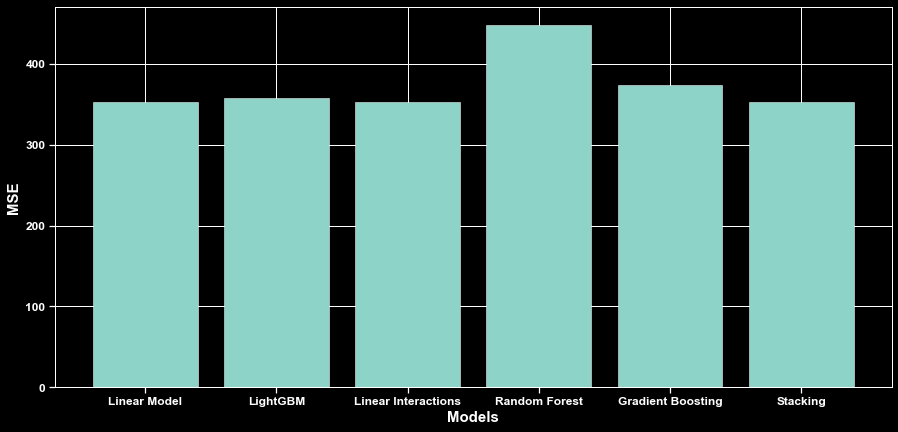

In [86]:
performance_plot()

### ---- 10 Select best model  ----

In [87]:
print(scores)

[353.5252995857336, 357.46084657710276, 353.5252995857336, 448.461081006837, 374.13344272548255, 353.53073985075804]


The Linear Model, Linear Model with interactions, and Stacking are incredibly close. But we will have to account for their performance on the training set and cross-validated standard deviations to ascertain stability.

- The linear model's score was 384, so we can exclude it.
- The interactions model's score was 354 with 0.77 standard deviation, which is quite solid.
- The stacked model's score was also 354 with 0.44 standard deviation, which is slightly better.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
- The stacked estimator combined a linear model and our best tree-based estimator - light GBM to capture both linear and non-linear associations in the data.
- It was also trained on interactions data because of its speed given by the lightGBM and linear regression.
- Since stacked learners typically outperform individual ensemble models, as evidenced above, we will use this our final model to deploy.

In [88]:
best_model = stack_pt

## Part 4 - DEPLOY

In [89]:
# create interactions to be able to train on the data
dummies = make_dummies(full_features_data)
drop_base_groups(dummies)
full_features_inter = create_interactions(dummies)
full_features_inter.shape

(999995, 378)

In [92]:
# train model on entire training set, saves model to disk, and predict on the predictions dataset
best_model.fit(full_features_inter, full_salary_data)

StackingRegressor(cv=None,
                  estimators=[('lr',
                               LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False)),
                              ('lgbm',
                               LGBMRegressor(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=12,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=63, objective=None,
                                       

In [93]:
# create interactions to be able to predict on the data
dummies_df = make_dummies(prediction_data)
drop_base_groups(dummies_df)
predictions_inter = create_interactions(dummies_df)
predictions_inter.shape

(1000000, 378)

In [94]:
predictions = best_model.predict(predictions_inter)
predictions

array([111.42926077,  92.84216366, 183.19299966, ...,  55.16535926,
       161.24500528, 112.34220183])

### ---- Deploy solution ----

Since there's no way to plot feature importances from a stacking regressor, we will plot feature importance from LightGBM which was in the stacked model.

In [95]:
lightGBM = LGBMRegressor().fit(full_features_inter, full_salary_data)

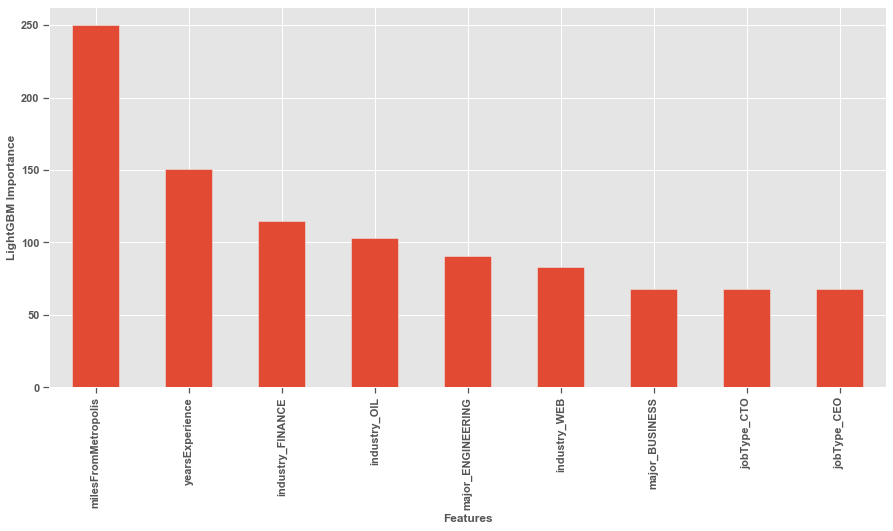

In [105]:
# visualizing feature importances
varimp = lightGBM.feature_importances_
np.sort(varimp) # top 10 values are 68 or above
top_nine = pd.DataFrame(varimp).iloc[varimp>=68].drop(27, axis=0) # drop 27th index as it is not present in dummy_train
names = dummy_train.iloc[:, top_nine.index.values.tolist()].columns # fetch names of column indeces from dummy_train set
top_nine = top_nine.transpose()
top_nine.columns = names # assign names
top_nine = top_nine.transpose()
top_nine.columns = ['Importance'] # label column
top_nine = top_nine.transpose()
row = top_nine.iloc[0].sort_values(ascending=False)
plt.figure(figsize=(15,7))
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.style.use('ggplot')
plt.xlabel('Features', fontweight='bold')
plt.ylabel('LightGBM Importance', fontweight='bold')
row.plot(kind='bar')

It appears that where a person lives is the most important predictor after controlling for all other factors and their influences on each other at each level of interaction. This is a somewhat surprising revelation, but it could speak to the effect of non-professional socio-economic factors in determining financial success and everything that leads up to it.
Experience, whether they are in the finance or oil industry, with or without an engineering background, etc. are also some of the most potent predictors of salary.

In [106]:
predictions = pd.DataFrame(predictions)
predictions.to_csv('salary_predictions.csv')